# Prepare some things

## Load some modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

import numpy as np

import sklearn.metrics
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

In [2]:
# Load the model class and some custom functions
import sys
sys.path.append('../')
from models import get_vae_model, get_dec_model, compute_p, compute_delta
from clustering_metrics import evaluate_model
from draw_embeddings import draw_embeddings, draw_clusters_assignments, compare_reconstructed_images_MNIST

## Load and prepare the MNIST data set

In [3]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())

x_train = x_train.reshape(-1, 28*28).astype("float")/255
x_test = x_test.reshape(-1, 28*28).astype("float")/255

# Construct the VAE based DEC model

## Load the pretrained VAE model

Construct the model and load the pretrained weights from the notebook [vae_on_MNIST.ipynb](./vae_on_MNIST.ipynb)

In [4]:
IMG_DIM = 28*28
LATENT_DIM = 10
INTERMEDIATE_DIMS = (512, 512, 2048)
N_CLUSTERS = 10

model_vae = get_vae_model(IMG_DIM, LATENT_DIM, INTERMEDIATE_DIMS)
model_vae.load_weights("model_weights/cvae/pretrained/vae")

## Construc the DEC model

In [5]:
encoder = models.Model(model_vae.encoder.inputs, model_vae.encoder.outputs[0])

model_dec = get_dec_model(encoder, N_CLUSTERS)

## Show the resulting embeddings

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


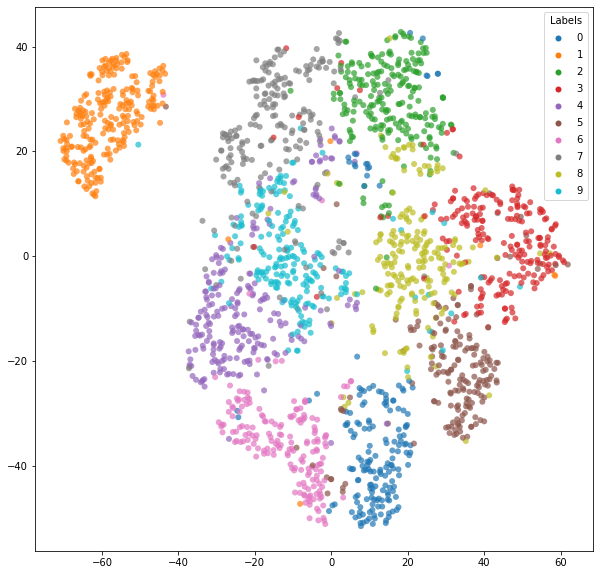

In [6]:
if LATENT_DIM == 2:
    z_train = model_dec.encode(x_train)
    draw_embeddings(z_train, y_train)
else:
    z_test = model_dec.encode(x_test)
    tsne = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_embeddings(z_tsne, y_test[0:2000], alpha=0.7)

# Fine-tune the model (K-Means)

## Initialize the parameters

In [7]:
EPOCHS = 100
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
# MOMENTUM = 0.9
SCHEDULE = 10
DELTA_THRESHOLD = 0.001

Initialize the model parameters from a K-means:

In [8]:
z_train = model_dec.encode(x_train)

kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=30)
kmeans.fit(z_train)

for weight in model_dec.trainable_weights:
    if weight.name == "centroids:0":
        weight.assign(K.constant(kmeans.cluster_centers_))

Initialize `p`, the auxiliary distribution to compute the clustering loss, and `c_last`, the last cluster assignments to compute the number of points that changed clusters.

In [9]:
p = compute_p(to_categorical(kmeans.labels_))
c_last = kmeans.labels_

Evaluate the clustering performance before fine-tunning the model:

{'Acc': 0.6112,
 'ARI': 0.4178752076334356,
 'AMI': 0.5339191645912688,
 'Sil': 0.16384485}

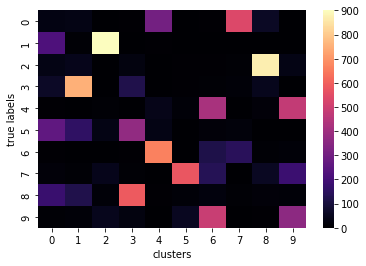

In [10]:
evaluate_model(model_dec.classify, model_dec.encode, x_test, y_test)

## Train the model

Train the model:

In [11]:
def dec_callback(epoch, logs):
    global p
    global c_last
    
    if (epoch+1) % SCHEDULE == 0:
        q = model_dec.soft_assignment(x_train)
        p = compute_p(q)
        
        c_new = q.numpy().argmax(1)
        delta = compute_delta(c_new, c_last)
        c_last = np.copy(c_new)
        print(f"Delta: {delta:.3f}")
        if (delta < DELTA_THRESHOLD):
            model_dec.stop_training = True
            
callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=dec_callback)

In [12]:
model_dec.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

model_dec.fit(x_train, p,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              callbacks = callback,
              verbose=2,
             )

model_dec.save_weights("model_weights/vae_dec/finetuned/dec_kmeans")

model_dec.load_weights("model_weights/vae_dec/finetuned/dec_kmeans")

Epoch 1/100
469/469 - 2s - loss: 8.4336 - 2s/epoch - 5ms/step
Epoch 2/100
469/469 - 2s - loss: 7.6293 - 2s/epoch - 4ms/step
Epoch 3/100
469/469 - 2s - loss: 7.1749 - 2s/epoch - 4ms/step
Epoch 4/100
469/469 - 2s - loss: 6.7650 - 2s/epoch - 3ms/step
Epoch 5/100
469/469 - 2s - loss: 6.3762 - 2s/epoch - 4ms/step
Epoch 6/100
469/469 - 2s - loss: 6.0133 - 2s/epoch - 3ms/step
Epoch 7/100
469/469 - 2s - loss: 5.6710 - 2s/epoch - 3ms/step
Epoch 8/100
469/469 - 2s - loss: 5.3488 - 2s/epoch - 4ms/step
Epoch 9/100
469/469 - 2s - loss: 5.0487 - 2s/epoch - 4ms/step
Epoch 10/100
Delta: 0.021
469/469 - 2s - loss: 4.7657 - 2s/epoch - 5ms/step
Epoch 11/100
469/469 - 2s - loss: 4.5006 - 2s/epoch - 3ms/step
Epoch 12/100
469/469 - 2s - loss: 4.2549 - 2s/epoch - 3ms/step
Epoch 13/100
469/469 - 2s - loss: 4.0220 - 2s/epoch - 4ms/step
Epoch 14/100
469/469 - 2s - loss: 3.8080 - 2s/epoch - 4ms/step
Epoch 15/100
469/469 - 2s - loss: 3.6028 - 2s/epoch - 3ms/step
Epoch 16/100
469/469 - 2s - loss: 3.4150 - 2s/epoch

## Show the resulting embeddings

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


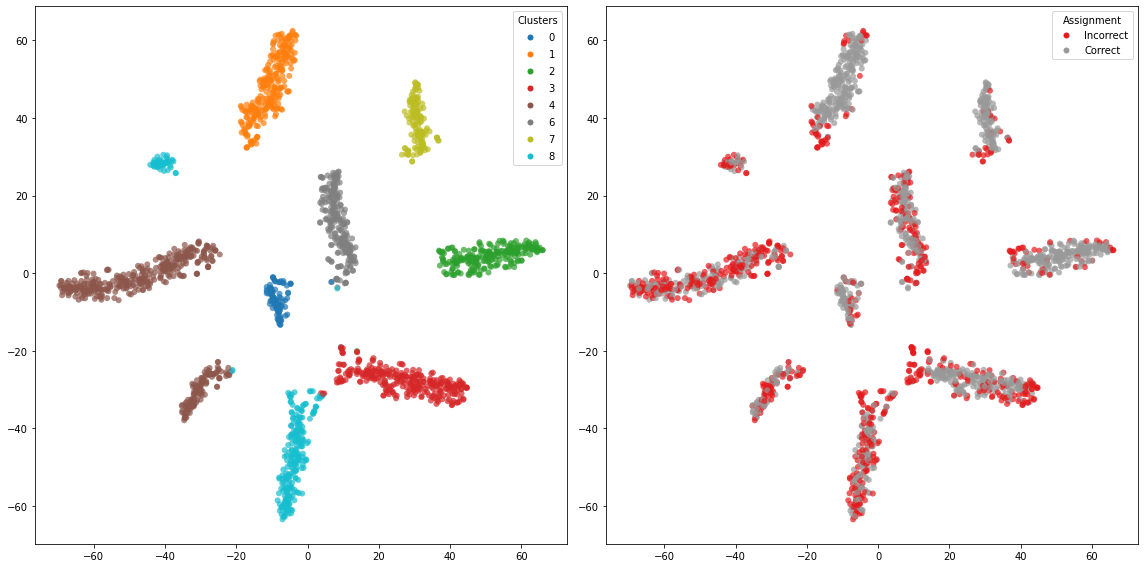

In [13]:
z_test = model_dec.encode(x_test)
c_test = model_dec.classify(x_test)

if LATENT_DIM == 2:
    draw_clusters_assignments(z_test, y_test, c_test)
else:
    tsne = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_clusters_assignments(z_tsne, y_test[0:2000], c_test[0:2000], alpha=0.7)

## Evaluate the model

{'Acc': 0.6132,
 'ARI': 0.4222826526935391,
 'AMI': 0.5384342740683908,
 'Sil': 0.9043608}

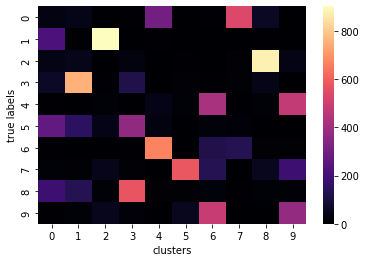

In [14]:
evaluate_model(model_dec.classify, model_dec.encode, x_test, y_test)

# Fine-tune the model (GMM)

## Construct the model and load the pretrained weights

Load the pretrained weights for the encoder and decoder modules:

In [15]:
model_vae = get_vae_model(IMG_DIM, LATENT_DIM, INTERMEDIATE_DIMS)
model_vae.load_weights("model_weights/cvae/pretrained/vae")
encoder = models.Model(model_vae.encoder.inputs, model_vae.encoder.outputs[0])
model_dec = get_dec_model(encoder, N_CLUSTERS)

In [16]:
EPOCHS = 100
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
# MOMENTUM = 0.9
SCHEDULE = 10
DELTA_THRESHOLD = 0.001

## Initialize the parameters

In [17]:
z_train = model_dec.encode(x_train)

gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag', n_init=10)
gmm.fit(z_train)

for weight in model_dec.trainable_weights:
    if weight.name == "centroids:0":
        weight.assign(K.constant(gmm.means_))

In [18]:
p = compute_p(to_categorical(gmm.predict(z_train)))
c_last = gmm.predict(z_train)

Evaluate the clustering performance before fine-tunning the model:

{'Acc': 0.6376,
 'ARI': 0.43526931590780904,
 'AMI': 0.5476284318561647,
 'Sil': 0.134405}

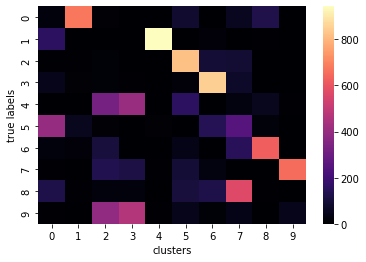

In [19]:
evaluate_model(model_dec.classify, model_dec.encode, x_test, y_test)

## Train the model

In [20]:
model_dec.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

model_dec.fit(x_train, p,
              epochs=EPOCHS,
              batch_size=128,
              callbacks = callback,
              verbose=2,
             )

model_dec.save_weights("model_weights/vae_dec/finetuned/dec_gmm")

model_dec.load_weights("model_weights/vae_dec/finetuned/dec_gmm")

Epoch 1/100
469/469 - 2s - loss: 9.4136 - 2s/epoch - 5ms/step
Epoch 2/100
469/469 - 2s - loss: 8.7736 - 2s/epoch - 4ms/step
Epoch 3/100
469/469 - 2s - loss: 8.3356 - 2s/epoch - 4ms/step
Epoch 4/100
469/469 - 2s - loss: 7.9267 - 2s/epoch - 3ms/step
Epoch 5/100
469/469 - 2s - loss: 7.5354 - 2s/epoch - 3ms/step
Epoch 6/100
469/469 - 2s - loss: 7.1620 - 2s/epoch - 3ms/step
Epoch 7/100
469/469 - 2s - loss: 6.8056 - 2s/epoch - 4ms/step
Epoch 8/100
469/469 - 2s - loss: 6.4688 - 2s/epoch - 3ms/step
Epoch 9/100
469/469 - 2s - loss: 6.1484 - 2s/epoch - 5ms/step
Epoch 10/100
Delta: 0.076
469/469 - 2s - loss: 5.8492 - 2s/epoch - 5ms/step
Epoch 11/100
469/469 - 2s - loss: 5.5593 - 2s/epoch - 4ms/step
Epoch 12/100
469/469 - 2s - loss: 5.2939 - 2s/epoch - 4ms/step
Epoch 13/100
469/469 - 2s - loss: 5.0441 - 2s/epoch - 3ms/step
Epoch 14/100
469/469 - 2s - loss: 4.8072 - 2s/epoch - 3ms/step
Epoch 15/100
469/469 - 2s - loss: 4.5798 - 2s/epoch - 3ms/step
Epoch 16/100
469/469 - 2s - loss: 4.3739 - 2s/epoch

## Show the resulting embeddings

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


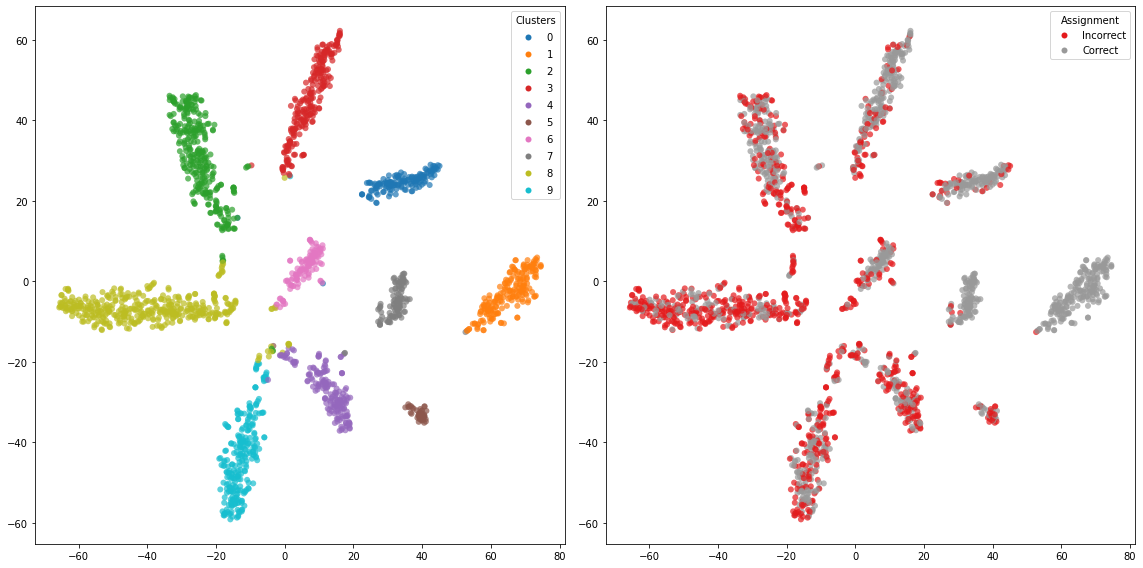

In [21]:
z_test = model_dec.encode(x_test)
c_test = model_dec.classify(x_test)

if LATENT_DIM == 2:
    draw_clusters_assignments(z_test, y_test, c_test)
else:
    tsne = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_clusters_assignments(z_tsne, y_test[0:2000], c_test[0:2000], alpha=0.7)

## Evaluate the model

{'Acc': 0.569,
 'ARI': 0.3129097737276735,
 'AMI': 0.4690800405814185,
 'Sil': 0.8670885}

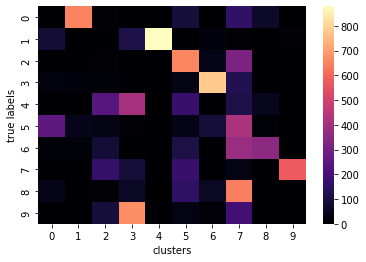

In [22]:
evaluate_model(model_dec.classify, model_dec.encode, x_test, y_test)